# Transport costs

## 📖 Ahead of time...

## 💻 Hands-on coding

In [1]:
import momepy
import geopandas
import contextily
import xarray, rioxarray
import osmnx as ox
import numpy as np
import matplotlib.pyplot as plt

In [2]:
ox.config(
    overpass_settings='[out:json][timeout:90][date:"2021-03-07T00:00:00Z"]'
)

### *Moving* along (street) networks


````{tabbed} Local files

Assuming you have the file locally on the path `../data/`: 

```python
streets = geopandas.read_file("../data/arturo_streets.gpkg")
abbs = geopandas.read_file("../data/madrid_abb.gpkg")
neis = geopandas.read_file("../data/neighbourhoods.geojson")
```
````

````{tabbed} Online read

If you're online, you can do:

```python
streets = geopandas.read_file(
    "https://darribas.org/gds4ae/_downloads/67d5480f98453027d59bf49606a7ad92/arturo_streets.gpkg"
)
abbs = geopandas.read_file(
    "https://github.com/GDSL-UL/san/raw/v0.1.0/data/assignment_1_madrid/madrid_abb.gpkg"
)
neis = geopandas.read_file(
    "http://darribas.org/gds4ae/_downloads/44b4bc22c042386c2c0f8dc6685ef17c/neighbourhoods.geojson"
)
```
````


In [3]:
streets = geopandas.read_file("../data/arturo_streets.gpkg")
abbs = geopandas.read_file("../data/madrid_abb.gpkg")
neis = geopandas.read_file("../data/neighbourhoods.geojson")

/opt/conda/lib/python3.8/site-packages/geopandas/geodataframe.py:577: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


#### Shortest-path routing

In [4]:
import pandana

Before building the routing network, we convert to graph and back in `momepy` to "clean" the network and ensure it complies with requirements for routing.

In [5]:
%%time
nodes, edges = momepy.nx_to_gdf(
    momepy.gdf_to_nx(
        streets.explode() # We "explode" to avoid multi-part rows
    )
)
nodes = nodes.set_index("nodeID") # Reindex nodes on ID

CPU times: user 5.3 s, sys: 28.1 ms, total: 5.33 s
Wall time: 5.33 s


Once we have nodes and edges "clean" from the graph representation, we can build a `pandana.Network` object we will use for routing:

In [6]:
streets_pdn = pandana.Network(
    nodes.geometry.x,
    nodes.geometry.y,
    edges["node_start"],
    edges["node_end"],
    edges[["mm_len"]]
)

streets_pdn

*How do I go from A to B?*

For example, from the first Airbnb in the geo-table...

In [7]:
first = abbs.loc[[0], :].to_crs(streets.crs)

...to Puerta del Sol.

In [8]:
import geopy
geopy.geocoders.options.default_user_agent = "gds4ae"
sol = geopandas.tools.geocode(
    "Puerta del Sol, Madrid", geopy.Nominatim
).to_crs(streets.crs)
sol

,geometry,address
0,POINT (440247.912 4474264.981),"Puerta del Sol, Sol, Centro, Madrid, Área metr..."


First we snap locations to the network:

In [9]:
pt_nodes = streets_pdn.get_node_ids(
    [first.geometry.x, sol.geometry.x], 
    [first.geometry.y, sol.geometry.y]
)
pt_nodes

0     3072
1    35732
Name: node_id, dtype: int64

Then we can route the shortest path:

In [10]:
route_nodes = streets_pdn.shortest_path(
    pt_nodes[0], pt_nodes[1]
)
route_nodes

array([ 3072,  3477,  8269,  8267,  8268, 18696, 18694,  1433,  1431,
         354,  8176,  8177, 18122, 17477, 16859, 14323, 16858, 17811,
       44796, 41221, 41218, 41222, 41653, 18925, 18929, 48944, 18932,
       21095, 21096, 23220, 15399, 15400, 15401, 47447, 47448, 23277,
       47449, 23260, 23261, 23262, 27952, 27953, 27954, 48328, 11951,
       11950, 11945, 19476, 19477, 27334, 30089, 43295, 11941, 11942,
       11943, 48326, 37485, 48317, 15894, 15891, 15892, 29955, 25454,
        7342, 34992, 23609, 28218, 21649, 21650, 21652, 39076, 25109,
       25103, 25102, 25101, 48519, 47288, 34624, 31188, 29616, 48557,
       22845, 48554, 48556, 40923, 40922, 40924, 48586, 46373, 46372,
       46371, 45676, 45677, 38779, 38778, 19145, 20499, 20498, 20500,
       47738, 42304, 42303, 35731, 35728, 35730, 35732])

With this information, we can build the route line manually:

````{margin}
```{attention}
The code to generate the route involves writing a function and is a bit more advanced than expected for this course. If this looks too complicated, do not despair.

Also, please note this builds a *simplified* line for the route, not one that is based on the original geometries (distance calculations *are* based on the original network).
```
````

In [11]:
from shapely.geometry import LineString

def route_nodes_to_line(nodes, network):
    pts = network.nodes_df.loc[nodes, :]
    s = geopandas.GeoDataFrame(
        {"src_node": [nodes[0]], "tgt_node": [nodes[1]]},
        geometry=[LineString(pts.values)],
        crs=streets.crs
    )
    return s

We can calculate the route:

In [12]:
route = route_nodes_to_line(route_nodes, streets_pdn)

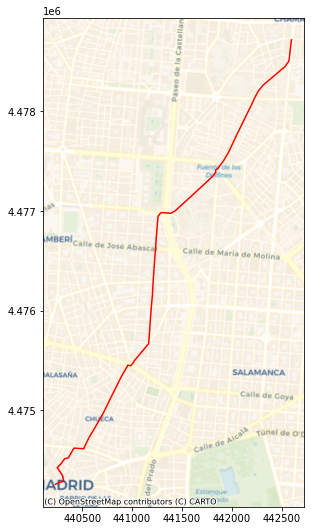

In [13]:
ax = route.plot(
    figsize=(9, 9),
    color="red"
)
contextily.add_basemap(
    ax, 
    crs=route.crs,
    source=contextily.providers.CartoDB.Voyager,
    zoom=14
)

And we get it back as a geo-table (with one row):

In [14]:
route

,src_node,tgt_node,geometry
0,3072,3477,"LINESTRING (442606.507 4478714.516, 442597.100..."


If we wanted to obtain the length of the route:

In [15]:
route_len = streets_pdn.shortest_path_length(
    pt_nodes[0], pt_nodes[1]
)
round(route_len / 1000, 3) # Dist in Km

5.514

#### "Third party-driven" routing

*How do I go from A to B passing by the "best" buildings?*

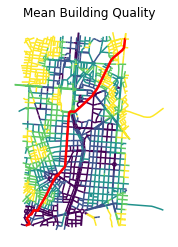

In [16]:
bb = route.total_bounds
ax = streets.cx[
    bb[0]: bb[2], bb[1]:bb[3]
].plot(
    "average_quality", scheme="quantiles"
)
route.plot(color="r", linewidth=2.5, ax=ax)
ax.set_title("Mean Building Quality")
ax.set_axis_off();

The overall process is the same; the main difference is, when we build the `Network` object, to replace distance (`mm_len`) with a measure that *combines* distance and building quality. Note that we want to *maximise* building quality, but the routing algorithms use a *minimisation* function. Hence, our composite index will need to reflect that.

The strategy is divided in the following steps:

1. Re-scale distance between 0 and 1
1. Build a measure inverse to building quality in the $[0, 1]$ range
1. Generate a combined measure (`wdist`) by picking a weighting parameter
1. Build a new `Network` object that incorporates `wdist` instead of distance
1. Compute route between the two points of interest

For 1., we can use the scaler in `scikit-learn`:

In [17]:
from sklearn.preprocessing import minmax_scale

Then generate and attach to `edges` a scaled version of `mm_len`:

In [18]:
edges["scaled_dist"] = minmax_scale(edges["mm_len"])

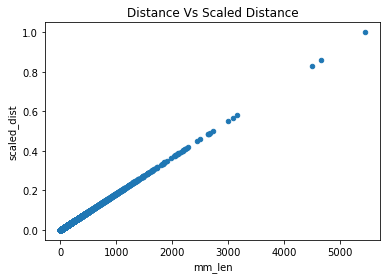

In [19]:
ax = edges.plot.scatter("mm_len", "scaled_dist")
ax.set_title("Distance Vs Scaled Distance");

We move on to 2., with a similar approach. We will use the negative of the building quality average (`average_quality`):

In [20]:
edges["scaled_inv_bquality"] = minmax_scale(
    -edges["average_quality"]
)

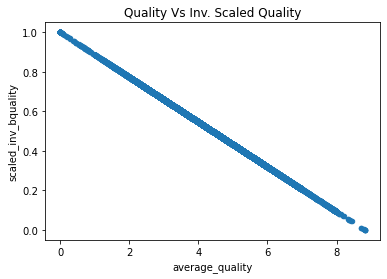

In [21]:
ax = edges.plot.scatter(
    "average_quality", "scaled_inv_bquality"
)
ax.set_title("Quality Vs Inv. Scaled Quality");

Taking 1. and 2. into 3. we can build `wdist`. For this example, we will give each dimension the same weight (0.5), but this is at discretion of the researcher.

In [22]:
w = 0.5
edges["wdist"] = (
    edges["scaled_dist"] * w +
    edges["scaled_inv_bquality"] * (1-w)
)

Now we can recreate the `Network` object based on our new measure (4.) and provide routing. Since it is the same process as with distance, we will do it all in one go:

In [23]:
# Build new graph object
w_graph = pandana.Network(
    nodes.geometry.x,
    nodes.geometry.y,
    edges["node_start"],
    edges["node_end"],
    edges[["wdist"]]
)
# Snap locations to their nearest node
pt_nodes = w_graph.get_node_ids(
    [first.geometry.x, sol.geometry.x], 
    [first.geometry.y, sol.geometry.y]
)
# Generate route
w_route_nodes = w_graph.shortest_path(
    pt_nodes[0], pt_nodes[1]
)
# Build LineString
w_route = route_nodes_to_line(
    w_route_nodes, w_graph
)

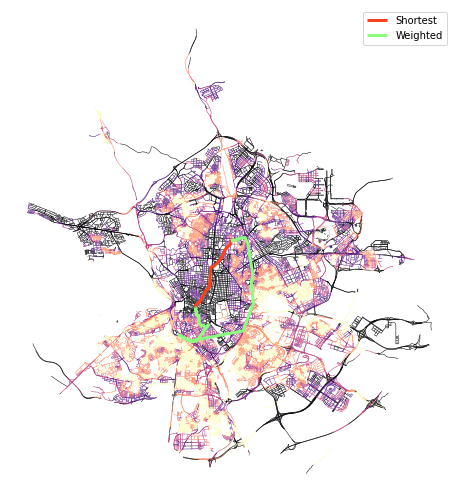

In [24]:
# Building quality
ax = streets.plot(
    "average_quality", 
    scheme="quantiles", 
    cmap="magma",
    linewidth=0.5,
    figsize=(9, 9)
)
# Shortest route
route.plot(
    color="xkcd:orange red", linewidth=3, ax=ax, label="Shortest"
)
# Weighted route
w_route.plot(
    color="xkcd:easter green", linewidth=3, ax=ax, label="Weighted"
)
# Styling
ax.set_axis_off()
plt.legend();

#### Proximity

*What is the nearest internet cafe for Airbnb's without WiFi?*

First we identify Airbnb's without WiFi:

In [25]:
no_wifi = abbs.query(
    "WiFi == '0'"
).to_crs(streets.crs)

Then pull WiFi spots in Madrid from OpenStreetMap:

In [26]:
icafes = ox.geometries_from_place(
    "Madrid, Spain", tags={"amenity": "internet_cafe"}
).to_crs(streets.crs)

/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


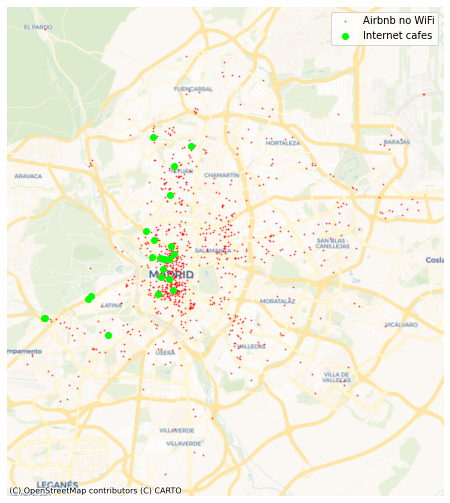

In [27]:
ax = no_wifi.plot(
    color="red", 
    markersize=1,
    alpha=0.5,
    label="Airbnb no WiFi",
    figsize=(9, 9)
)
icafes.plot(
    ax=ax, color="lime", label="Internet cafes"
)
contextily.add_basemap(
    ax, 
    crs=no_wifi.crs,
    source=contextily.providers.CartoDB.Voyager
)
ax.set_axis_off()
plt.legend()
plt.show()

The logic for this operation is the following:

1. Add the points of interest (POIs, the internet cafes) to the network object (`streets_pdn`)
1. Find the nearest node to each POI
1. Find the nearest node to each Airbnb without WiFi
1. Connect each Airbnb to its nearest internet cafe

We can add the internet cafes to the network object (1.) with the `set_pois` method:

```{margin}
Note we set `max_items=1` because we are only going to query for the nearest cafe. This will make computations much faster
```

In [28]:
import numpy as np

streets_pdn.set_pois(
    category="Internet cafes",
    maxitems=1,
    maxdist=100000, # 100km so everything is included
    x_col=icafes.geometry.x,
    y_col=icafes.geometry.y,
)

/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/opt/conda/lib/python3.8/site-packages/pandana/network.py:660: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/opt/conda/lib/python3.8/site-packages/pandana/network.py:668: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):


Once the cafes are added to the network, we can find the nearest one to each node (2.):

```{margin}
Note there are some nodes for which we can't find a nearest cafe. These are related to disconnected parts of the network
```

In [29]:
cafe2nnode = streets_pdn.nearest_pois(
    100000,              # Max distance to look for
    "Internet cafes",    # POIs to look for
    num_pois=1,          # No. of POIs to include
    include_poi_ids=True # Store POI ID
# Then add the internet cafee IDs and name
).join(
    icafes[["unique_id", "osmid", "name"]],
    on="poi1"
# Rename the distance from node to cafe
).rename(
    columns={1: "dist2icafe"}
)
cafe2nnode.info()

/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 49985 entries, 1 to 49985
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   dist2icafe  49985 non-null  float64
 1   poi1        49113 non-null  float64
 2   unique_id   49113 non-null  object 
 3   osmid       49113 non-null  float64
 4   name        25684 non-null  object 
dtypes: float64(3), object(2)
memory usage: 3.3+ MB


Note that, to make things easier down the line, we can link `cafe2nnode` to the cafe IDs.

And we can also link Airbnb's to nodes (3.) following a similar approach as we have seen above:

In [30]:
abbs_nnode = streets_pdn.get_node_ids(
    no_wifi.geometry.x, no_wifi.geometry.y
)
abbs_nnode.head()

/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


26      8873
50     10906
62     41159
63     34258
221    32216
Name: node_id, dtype: int64

Finally, we can bring together both to find out what is the nearest internet cafe for each Airbnb (4.):

In [31]:
abb_icafe = no_wifi[
    ["geometry"]
].assign(
    nnode=abbs_nnode
).join(
    cafe2nnode, on="nnode"
)
abb_icafe.head()

/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,geometry,nnode,dist2icafe,poi1,unique_id,osmid,name
26,POINT (443128.256 4483599.841),8873,4926.223145,9.0,node/3770327498,3.770327e+09,Silver Envíos 2
50,POINT (441885.677 4475916.602),10906,1876.392944,19.0,node/6922981312,6.922981e+09,Locutorio
62,POINT (440439.640 4476480.771),41159,1164.812988,17.0,node/5573414444,5.573414e+09,NaN
63,POINT (438485.311 4471714.377),34258,1466.537964,5.0,node/2304484515,2.304485e+09,NaN
221,POINT (439941.104 4473117.914),32216,354.268005,15.0,node/5412144560,5.412145e+09,NaN


#### Accessibility

In [32]:
%%time
parks = ox.geometries_from_place(
    "Madrid, Spain", tags={"leisure": "park"}
).to_crs(streets.crs)

/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


CPU times: user 429 ms, sys: 12 ms, total: 441 ms
Wall time: 437 ms


*How many parks are within 500m(-euclidean) of an Airbnb?*

We draw a radious of 500m around each AirBnb:

In [33]:
buffers = geopandas.GeoDataFrame(
    geometry=abbs.to_crs(
        streets.crs
    ).buffer(
        500
    )
)

/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Then intersect it with the location of parks, and count by buffer (ie. Airbnb):

In [34]:
park_count = geopandas.sjoin(
    parks, buffers
).groupby(
    "index_right"
).size()

*How many parks are within 500m(-network) of an Airbnb?*

We need to approach this as a calculation *within* the network. The logic of steps thus looks like:

1. Use the aggregation module in `pandana` to count the number of parks within 500m of each node in the network
1. Extract the counts for the nodes nearest to Airbnb properties
1. Assign park counts to each Airbnb


We can set up the aggregate engine (1.). This involves three steps: 

a. Obtain nearest node for each park

In [35]:
parks_nnode = streets_pdn.get_node_ids(
    parks.centroid.x, parks.centroid.y
)

/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


b. Insert the parks' nearest node through `set` so it can be "aggregated"


In [36]:
streets_pdn.set(
    parks_nnode, name="Parks"
)

/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


c. "Aggregate" for a distance of 500m, effectively counting the number of parks within 500m of each node

In [37]:
parks_by_node = streets_pdn.aggregate(
    distance=500, type="count", name="Parks"
)
parks_by_node.head()

/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


nodeID
1    5.0
2    5.0
3    6.0
4    8.0
5    1.0
dtype: float64

At this point, we have the number of parks within 500m of *every* node in the network. To identify those that correspond to each Airbnb (3.), we query those nodes:

In [38]:
abbs_xys = abbs.to_crs(streets.crs).geometry
abbs_nnode = streets_pdn.get_node_ids(
    abbs_xys.x, abbs_xys.y
)

And use the list to asign the count of the nearest node to each Airbnb:

In [39]:
park_count_network = abbs_nnode.map(
    parks_by_node
)

/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


*For which areas do both differ most?*

We can compare the two counts above to explore to what extent the street layout is constraining access to nearby parks.

In [40]:
park_comp = geopandas.GeoDataFrame(
    {
        "Euclidean": park_count, 
        "Network": park_count_network
    },
    geometry=abbs.geometry,
    crs=abbs.crs
)

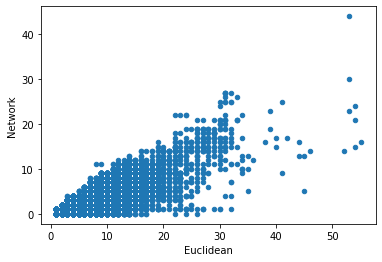

In [41]:
park_comp.plot.scatter("Euclidean", "Network");

And, geographically:

```{margin}
Note there are a few cases where there are more network counts than Euclidean. These are due to the slight inaccuracies introduced by calculating network distances from nodes rather than the locations themselves
```

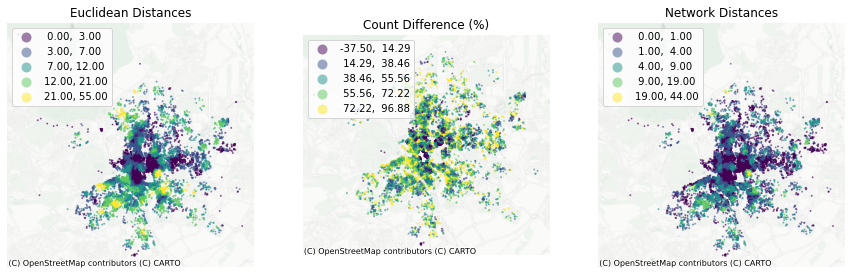

In [42]:
f, axs = plt.subplots(1, 3, figsize=(15, 5))

# Euclidean count
abbs.to_crs(
    streets.crs
).assign(
    n_parks=park_count
).fillna(0).plot(
    "n_parks", 
    scheme="fisherjenkssampled", 
    alpha=0.5,
    markersize=1,
    figsize=(9, 9),
    legend=True,
    ax=axs[0]
)
contextily.add_basemap(
    axs[0], 
    crs=streets.crs,
    source=contextily.providers.CartoDB.PositronNoLabels
)
axs[0].set_axis_off()
axs[0].set_title("Euclidean Distances")

# Count difference
with_parks = park_comp.query(
    "(Network > 0) & (Euclidean > 0)"
)
count_diff = 100 * (
    with_parks["Euclidean"] - 
    with_parks["Network"]
) / with_parks["Euclidean"]
abbs.to_crs(
    streets.crs
).assign(
    n_parks=count_diff
).dropna().plot(
    "n_parks", 
    scheme="fisherjenkssampled", 
    alpha=0.5,
    markersize=1,
    figsize=(9, 9),
    legend=True,
    ax=axs[1]
)
contextily.add_basemap(
    axs[1], 
    crs=streets.crs,
    source=contextily.providers.CartoDB.PositronNoLabels
)
axs[1].set_axis_off()
axs[1].set_title("Count Difference (%)")

# Network count
abbs.to_crs(
    streets.crs
).assign(
    n_parks=park_count_network
).fillna(0).plot(
    "n_parks", 
    scheme="fisherjenkssampled", 
    alpha=0.5,
    markersize=1,
    figsize=(9, 9),
    legend=True,
    ax=axs[2]
)
contextily.add_basemap(
    axs[2], 
    crs=streets.crs,
    source=contextily.providers.CartoDB.PositronNoLabels
)
axs[2].set_axis_off()
axs[2].set_title("Network Distances")

plt.show()

### *Moving* along surfaces


````{tabbed} Local files

Assuming you have the file locally on the path `../data/`: 

```python
friction_walk = rioxarray.open_rasterio(
    "../data/cambodia_2020_walking_friction_surface.tif"
)
friction_motor = rioxarray.open_rasterio(
    "../data/cambodia_2020_motorized_friction_surface.tif"
)
cities = geopandas.read_file("../data/cambodian_cities.geojson")
```
````

````{tabbed} Online read

If you're online, you can do:

```python
friction_walk = rioxarray.open_rasterio(
    "https://darribas.org/gds4ae/_downloads/481f40ab3d2922d5e00b084b3668314b/cambodia_2020_walking_friction_surface.tif"
)
friction_motor = rioxarray.open_rasterio(
    "https://darribas.org/gds4ae/_downloads/f41b238a4d072a8a3eb5ce1794cd126a/cambodia_2020_motorized_friction_surface.tif"
)
cities = geopandas.read_file(
    "https://darribas.org/gds4ae/_downloads/b2bc4ad46ffb5fcec467286c022adf14/cambodian_cities.geojson"
)
```
````


In [43]:
friction_walk = rioxarray.open_rasterio(
    "../data/cambodia_2020_walking_friction_surface.tif"
)
friction_motor = rioxarray.open_rasterio(
    "../data/cambodia_2020_motorized_friction_surface.tif"
)
cities = geopandas.read_file("../data/cambodian_cities.geojson")

/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


#### Shortest-path routing

In [44]:
import osmnx as ox

/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


```python
main_roads = ox.geometries_from_place(
    "Cambodia", tags={"highway": "trunk"}
)
```

In [45]:
# Try read locally
try:
    main_roads = geopandas.read_file("../data/cambodia_roads_cache.gpkg")
# Download/write otherwise
except:
    main_roads = ox.geometries_from_place(
        "Cambodia", tags={"highway": "trunk"}
    )
    main_roads.to_file(
        "../data/cambodia_roads_cache.gpkg", driver="GPKG"
    )

/opt/conda/lib/python3.8/site-packages/geopandas/geodataframe.py:577: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


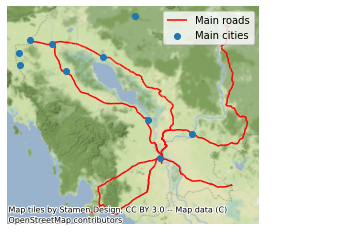

In [46]:
ax = main_roads.plot(
    color="red", label="Main roads"
)
cities.plot(
    ax=ax, zorder=2, label="Main cities"
)
contextily.add_basemap(
    ax, 
    crs=main_roads.crs, 
    source=contextily.providers.Stamen.TerrainBackground
)
ax.set_axis_off()
plt.legend();

From the geo-table of roads, we can generate a surface that has a value of 1 on cells where a road crosses, and 0 otherwise (*rasterisation*).

In [47]:
from geocube.api.core import make_geocube

roads_surface = make_geocube(
    main_roads.assign(
        one=1
    ).to_crs(epsg=3148),
    measurements=["one"],
    resolution=(500, 500)
)["one"]

/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Now we turn it into a binary mask:

In [48]:
road_mask = xarray.where(
    roads_surface.isnull(), 0, 1
)

/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


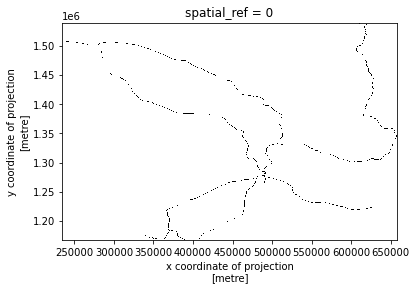

In [49]:
road_mask.plot(
    cmap="Greys", add_colorbar=False
);

In [50]:
road_mask

<xarray.DataArray 'one' (y: 745, x: 847)>
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])
Coordinates:
  * y            (y) float64 1.167e+06 1.168e+06 ... 1.539e+06 1.539e+06
  * x            (x) float64 2.348e+05 2.352e+05 ... 6.572e+05 6.578e+05
    spatial_ref  int64 0

Then we can generate the routing from, say Phnom Penh to Poipet, using `xarray-spatial`'s A* algorithm:

In [51]:
a_star_search?

Object `a_star_search` not found.


In [52]:
from xrspatial import a_star_search

# Pull out starting point
start = cities.query(
    "UC_NM_MN == 'Phnom Penh'"
).to_crs(
    epsg=3148
).squeeze().geometry

# Pull out ending point
end = cities.query(
    "UC_NM_MN == 'Poipet'"
).to_crs(
    epsg=3148
).squeeze().geometry

# Routing
route = a_star_search(
    road_mask,          # Road surface
    (start.x, start.y), # Starting point
    (end.x, end.y),     # Destination point
    barriers=[0],       # Cell values that cannot be crossed
    snap_start=True,    # Snap starting point to valid cells
    snap_goal=True      # Snap ending point to valid cells
)

/opt/conda/lib/python3.8/site-packages/numba/cuda/api.py:112: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  def device_array(shape, dtype=np.float, strides=None, order='C', stream=0):
/opt/conda/lib/python3.8/site-packages/numba/cuda/api.py:124: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  def managed_array(shape, dtype=np.float, strides

/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


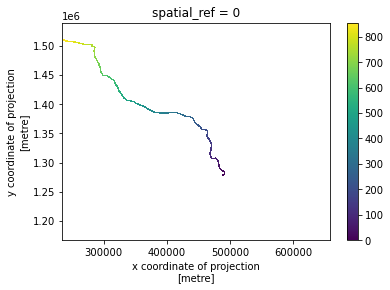

In [53]:
route.plot()

In [54]:
route

<xarray.DataArray (y: 745, x: 847)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * y            (y) float64 1.167e+06 1.168e+06 ... 1.539e+06 1.539e+06
  * x            (x) float64 2.348e+05 2.352e+05 ... 6.572e+05 6.578e+05
    spatial_ref  int64 0

And we can turn the route surface into a line that connects the pixels in the route:

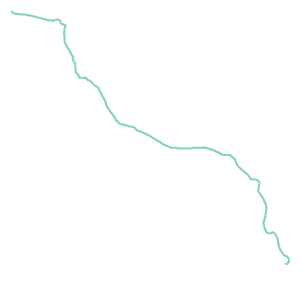

In [55]:
from shapely.geometry import LineString

route_line = LineString(
    route.to_series().dropna().reset_index().rename(
        columns={0: "order"}
    ).sort_values(
        "order"
    )[
        ["x", "y"]
    ].values
)
route_line

#### Continuous surfaces

We can use a continuous surface instead of a road network to set the surface cells where it is allowed to "pass". For example, with the motorised surface, we can explore the degree of friction:

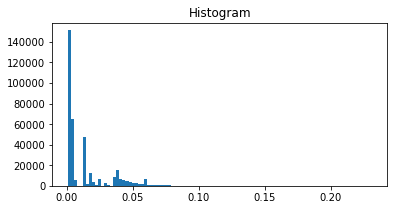

In [56]:
friction_motor.where(
    friction_motor!=friction_motor.rio.nodata
).plot.hist(
    bins=100, figsize=(6, 3)
);

We can determine that, above 0.01, a cell is not available for routing. Using this, we can build a mask similar as above that can be used for generating routes:

In [57]:
# Set surface up
surface = friction_motor.where(
    friction_motor!=friction_motor.rio.nodata
).rio.reproject(3148).sel(
    band=1
)
# Swap nodata value for N/A
surface = surface.where(
    surface!=surface.rio.nodata
)
# Turn into binary mask
# Valid for routing if < 0.01
surface = xarray.where(
    surface < 0.01, 1, 0
)

/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [58]:
# Swap order of Y coordinate
surface.coords["y"] = surface.coords["y"][::-1]

# Pull out starting point
start = cities.query(
    "UC_NM_MN == 'Siem Reap'"
).to_crs(
    epsg=3148
).squeeze().geometry

# Pull out ending point
end = cities.query(
    "UC_NM_MN == 'Sihanoukville'"
).to_crs(
    epsg=3148
).squeeze().geometry

# Routing
route = a_star_search(
    surface,            # (Reprojected) road surface
    (start.x, start.y), # Starting point
    (end.x, end.y),     # Destination point
    barriers=[0],       # Cell values that cannot be crossed
    snap_start=True,    # Snap starting point to valid cells
    snap_goal=True      # Snap ending point to valid cells  
)

# Swap order of Y coordinate back
surface.coords["y"] = surface.coords["y"][::-1]

# Parse route into line
route_line = LineString(
    route.to_series().dropna().reset_index().rename(
        columns={0: "order"}
    ).sort_values(
        "order"
    )[
        ["x", "y"]
    ].values
)
route_line = geopandas.GeoSeries([route_line])

/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


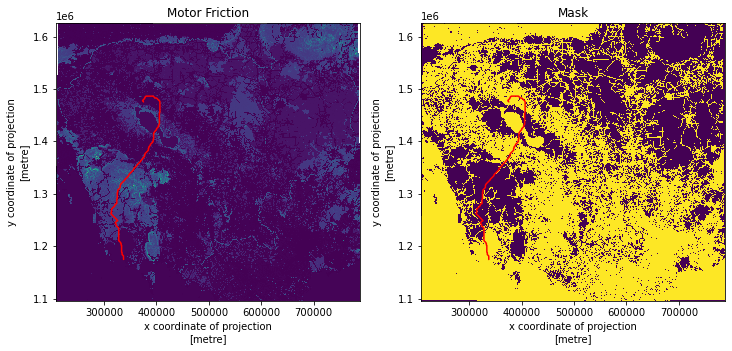

In [59]:
f, axs = plt.subplots(1, 2, figsize=(12, 6))

friction_motor.rio.reproject(
    3148
).sel(
    band=1
).where(
    friction_motor.rio.reproject(3148)>0
).plot(ax=axs[0], add_colorbar=False)
route_line.plot(
    ax=axs[0], color="red"
)
axs[0].set_title("Motor Friction")

surface.plot(ax=axs[1], add_colorbar=False)
route_line.plot(
    ax=axs[1], color="red"
)
axs[1].set_title("Mask")

plt.show();

/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


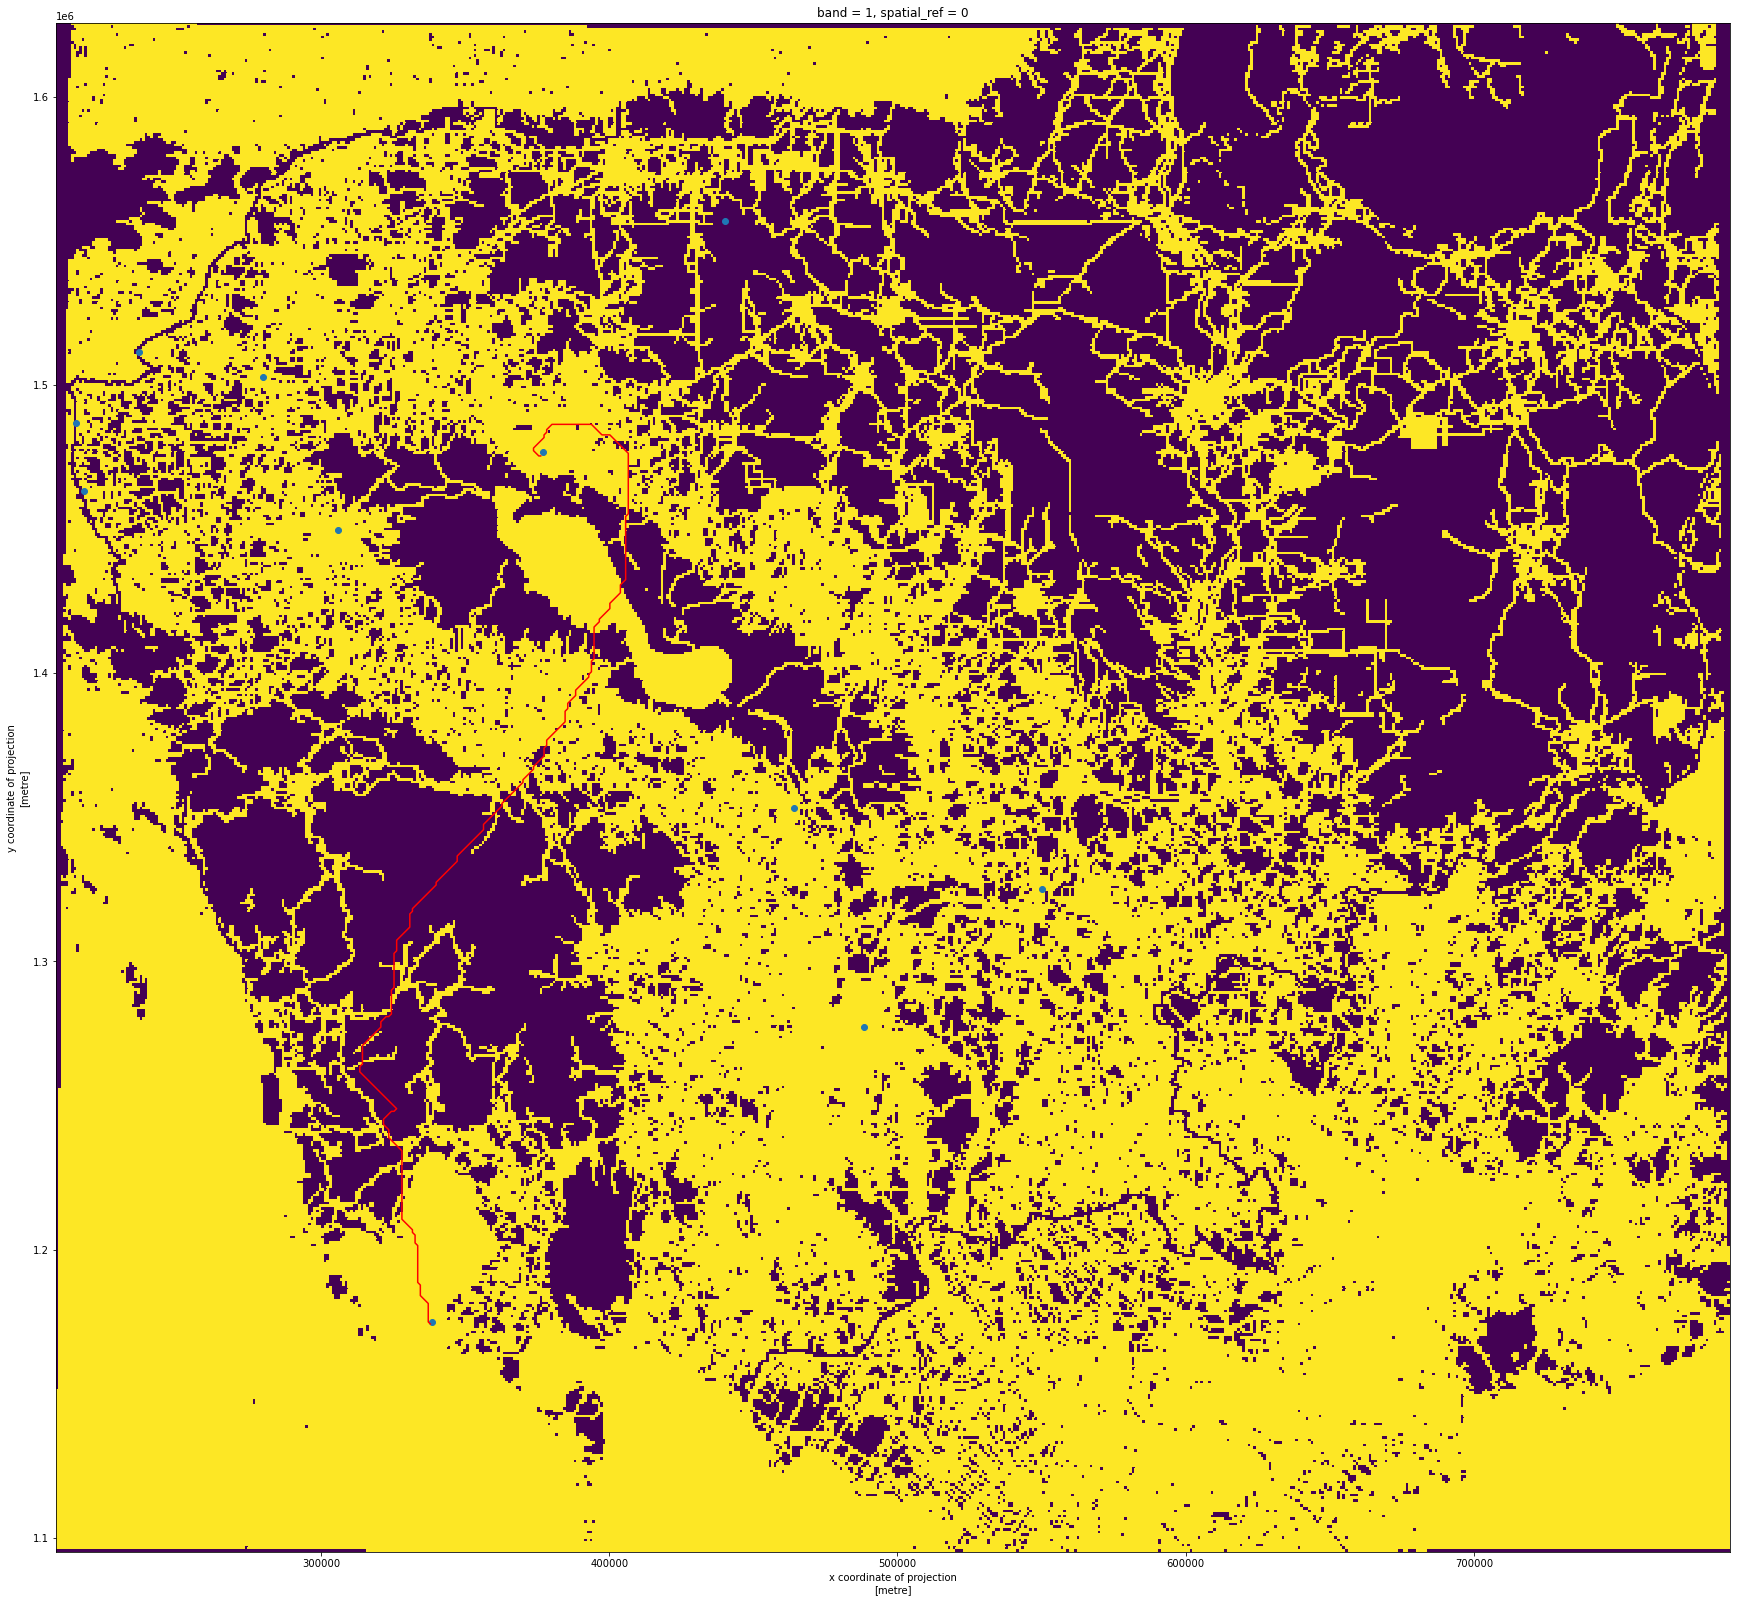

In [60]:
f, ax = plt.subplots(1, figsize=(30, 30))
surface.plot(add_colorbar=False)
route_line.plot(
    ax=ax, color="red"
)
cities.to_crs(epsg=3148).plot(
    ax=ax, label="Main cities"
)
plt.show()

### Over to you...

- Recreate weighted routing using the linearity of street segments. How can you go from A to B avoiding long streets?
- Explore the differences in the output of weighted routing if you change the weight between distance and the additional variable.
- Explore the difference in routing when you vary the friction threshold to allow usage of a cell

## 🐾 Next steps

If you found the content in this block useful, the following resources represent some suggestions on where to go next:

- The [`pandana` tutorial](https://github.com/UDST/pandana/blob/master/examples/Pandana-demo.ipynb) and [documentation](http://udst.github.io/pandana/index.html) are excellent places to get a more detailed and comprehensive view into the functionality of the library
- More about `xarray-spatial`, the library that provides geospatial techniques on top of surfaces is available at the project's [documentation](https://makepath.github.io/xarray-spatial/)